In [1]:
import csv
import numpy as np
import tifffile as tf
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import ndimage
import pandas as pd
import os

In [3]:
import cv2

In [2]:
# Load the TIFF stack and extract shape information
file_path = 'data_from_paper.ome.tif'
stack = tf.imread(file_path)
print('Loading Done')

<tifffile.TiffFile 'data_from_paper.ome.tif'> MMStack file name is invalid
<tifffile.TiffFile 'data_from_paper.ome.tif'> MMStack series is missing files. Returning subset (9949, 1, 1, 1) of (10000, 1, 1, 1)


Loading Done


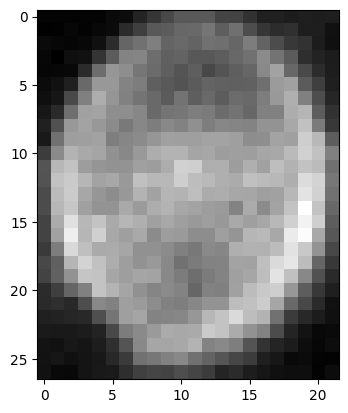

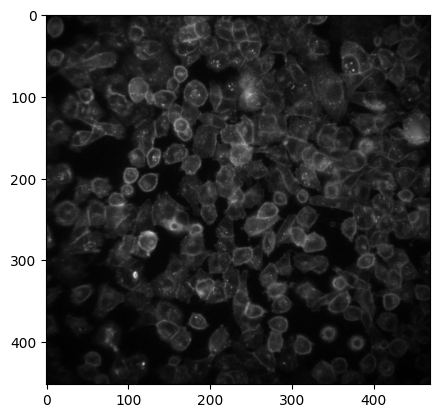

In [3]:
plt.imshow(stack[0, 3:30, :22], cmap='gray')
plt.show()
plt.imshow(stack[0, :, :], cmap='gray')
plt.show()

In [5]:
batch_size = 100  # Adjust the batch size as needed
total_indices = len(stack)
num_batches = total_indices // batch_size + (1 if total_indices % batch_size != 0 else 0)
origin = (1000//2 - 1)

def filtering(x, y):
    batch_size = 100  # Adjust the batch size as needed
    total_indices = len(stack)
    num_batches = total_indices // batch_size + (1 if total_indices % batch_size != 0 else 0)
    origin = (1000//2 - 1)
    raw_time_series = stack[:, x, y]
    result_data = []

    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        end_index = min((batch_idx + 1) * batch_size, total_indices)

        processed_time_series_batch = np.zeros((end_index - start_index))
        result_data_batch = np.zeros((end_index // 2) + 1)

        for index in range(start_index, end_index):
            # Your processing code for each index within the batch
            

            # Perform filtering
            filtered = ndimage.uniform_filter(raw_time_series[:index + 1], size=1000, mode='nearest',
                                            origin=origin)
            processed_time_series_batch[index - start_index] = filtered[index]
            
            if index % 2 == 0:
                blue_unf = raw_time_series[index]
                green_unf = raw_time_series[index - 1]
                blue_f = processed_time_series_batch[index - start_index]
                green_f = processed_time_series_batch[index - start_index - 1]

                # Avoid division by zero
                blue_channel = np.divide(blue_unf, blue_f, out=np.zeros_like(blue_f), where=blue_f != 0)
                green_channel = np.divide(green_unf, green_f, out=np.zeros_like(green_f), where=green_f != 0)
                frame = np.divide(blue_channel, green_channel, out=np.zeros_like(green_channel), where=green_channel != 0)

                idx = int(index / 2)
                result_data_batch[idx] = frame

        result_data.append(result_data_batch)
    return result_data

In [6]:
result_data = filtering(14, 19)

In [7]:
for i in range(len(result_data)):
    result_data[i] = result_data[i][result_data[i] != 0]

In [8]:
result_data = np.concatenate(result_data)
result_data

array([0.79765739, 0.76854257, 0.79204289, ..., 0.80893953, 0.82510244,
       0.7949796 ])

In [9]:
len(result_data)

4875

In [20]:
result_data_gaussian = ndimage.gaussian_filter(result_data, 3)

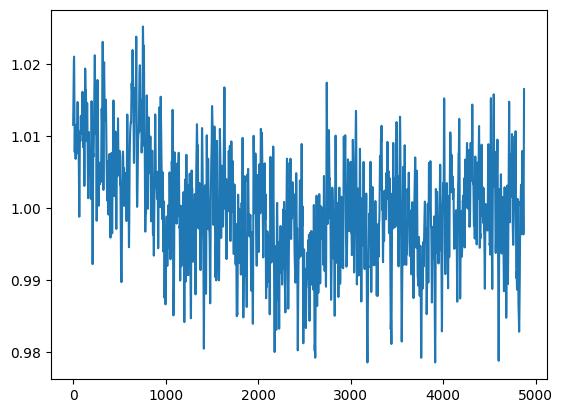

In [21]:
mn = np.mean(result_data_gaussian)
result_data_gaussian_mn = result_data_gaussian - mn
offset = 1 - np.mean(result_data_gaussian_mn)
sym_data = result_data_gaussian_mn + offset
plt.plot(sym_data)
plt.show()

In [24]:
data = pd.read_csv('cancer_20201218_slip1_area4_long_acq_long_acq_blue_0.0318_green_0.0772_heated_to_37_TTX_washout_1_active_timeseries.csv')

In [25]:
data = data.drop(data.columns[0], axis=1)
data

,0,1,2,3,4,5,6,7,8,9,...,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998
0,1.000709,1.000798,1.000950,1.001118,1.001259,1.001348,1.001389,1.001413,1.001461,1.001567,...,1.003459,1.003142,1.002836,1.002609,1.002507,1.002539,1.002674,1.002858,1.003026,1.003125
1,1.000860,1.000886,1.000911,1.000899,1.000833,1.000719,1.000579,1.000440,1.000317,1.000220,...,1.002319,1.002408,1.002492,1.002520,1.002470,1.002357,1.002224,1.002115,1.002050,1.002023
2,0.998977,0.998866,0.998661,0.998393,0.998098,0.997819,0.997608,0.997511,0.997563,0.997762,...,1.002743,1.002387,1.002054,1.001821,1.001738,1.001808,1.001988,1.002210,1.002404,1.002514
3,0.999559,0.999529,0.999516,0.999582,0.999763,1.000037,1.000326,1.000536,1.000599,1.000506,...,1.007385,1.006754,1.006067,1.005435,1.004959,1.004699,1.004649,1.004740,1.004878,1.004972
4,1.001156,1.001082,1.000947,1.000773,1.000591,1.000428,1.000311,1.000249,1.000228,1.000214,...,1.002244,1.002033,1.001796,1.001586,1.001442,1.001374,1.001370,1.001400,1.001438,1.001462
5,1.000985,1.000931,1.000818,1.000645,1.000415,1.000148,0.999878,0.999648,0.999491,0.999423,...,1.001632,1.001277,1.000958,1.000722,1.000604,1.000618,1.000748,1.000942,1.001129,1.001243
6,0.998615,0.998374,0.997978,0.997563,0.997254,0.997114,0.997130,0.997230,0.997325,0.997357,...,1.005083,1.004912,1.004690,1.004402,1.004032,1.003572,1.003041,1.002501,1.002049,1.001790
7,1.003042,1.002921,1.002669,1.002284,1.001786,1.001229,1.000683,1.000210,0.999836,0.999548,...,1.005463,1.005063,1.004624,1.004190,1.003778,1.003392,1.003037,1.002728,1.002493,1.002365
8,0.998250,0.998249,0.998248,0.998256,0.998285,0.998346,0.998448,0.998583,0.998730,0.998860,...,1.002281,1.002652,1.003092,1.003543,1.003917,1.004133,1.004161,1.004037,1.003856,1.003730
9,1.003003,1.002959,1.002912,1.002917,1.003006,1.003160,1.003307,1.003358,1.003248,1.002972,...,1.001182,1.001050,1.000995,1.001065,1.001289,1.001658,1.002122,1.002597,1.002987,1.003205


In [26]:
x_axis = data.columns
y_axis = data.iloc[8].to_list()
y_axis

[0.9982501946557052,
 0.9982486472646228,
 0.9982484934265446,
 0.9982564033676292,
 0.9982845213684228,
 0.9983461466858324,
 0.9984478553277,
 0.998583010173131,
 0.9987297320732362,
 0.9988595511525422,
 0.998947085419825,
 0.9989806771113834,
 0.9989643422840048,
 0.998917155088622,
 0.9988689016603634,
 0.9988542406070328,
 0.9989040610161468,
 0.9990356703159766,
 0.9992466581598524,
 0.999514260978436,
 0.9998041055093192,
 1.000080260002789,
 1.0003103278313878,
 1.0004627840600686,
 1.00050557244091,
 1.000414934549304,
 1.0001937884910683,
 0.9998875337356918,
 0.999582004941777,
 0.9993748666072853,
 0.9993369240524106,
 0.9994842260833678,
 0.9997771595260704,
 1.0001424361602107,
 1.0005000895384424,
 1.0007854797713271,
 1.0009574099485696,
 1.0009994393450736,
 1.0009159258824103,
 1.0007253736848782,
 1.000450712432237,
 1.0001099327458398,
 0.9997101661661388,
 0.9992507119201844,
 0.9987330330011198,
 0.9981706184086914,
 0.9975942417346128,
 0.9970514532207904,
 0.99

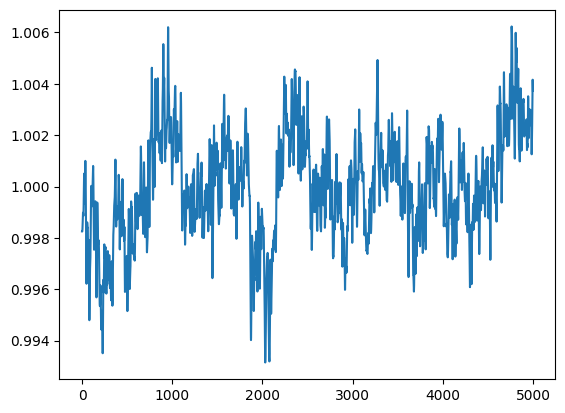

In [27]:
plt.plot(y_axis)
plt.show()

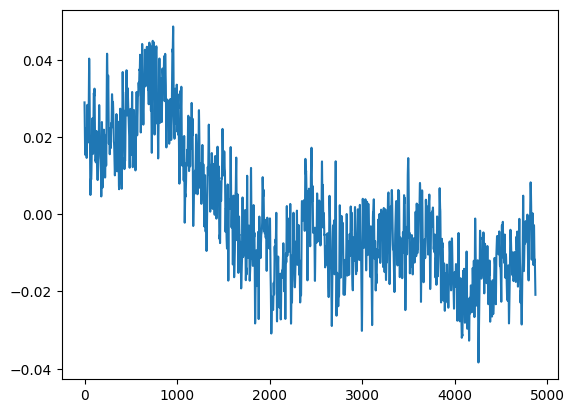

In [72]:
error = y_axis[:4875] - sym_data
plt.plot(error)
plt.show()

In [74]:
np.mean(error)

-6.742108191417483e-05